I am running this apache spark locally from my computer, and it seems that I am running out of memory due to the size of the dataset. Thus, in this submission I will do the explanatory data analysis in pyspark with only limited dataframe from ml-20m dataaset. And do a simple analysis using matrix correlation pearson

### Preprocessing

In [1]:
# set up the environment
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, avg

In [2]:
# Initialize Spark
# conf = SparkConf().setAppName("MySparkApp")
# sc = SparkContext(conf=conf)
# spark = SparkSession(sc)

spark = SparkSession.builder \
    .appName("MySparkApp") \
    .getOrCreate()

In [3]:
# Read a CSV file
rating = spark.read.csv("ml-20m/ratings.csv", header=True, inferSchema=True)
movie = spark.read.csv("ml-20m/movies.csv", header=True, inferSchema=True)

In [4]:
df = rating.join(movie, on='movieId', how='left')
df = df.drop('timestamp')
df.show()

+-------+------+------+--------------------+--------------------+
|movieId|userId|rating|               title|              genres|
+-------+------+------+--------------------+--------------------+
|      2|     1|   3.5|      Jumanji (1995)|Adventure|Childre...|
|     29|     1|   3.5|City of Lost Chil...|Adventure|Drama|F...|
|     32|     1|   3.5|Twelve Monkeys (a...|Mystery|Sci-Fi|Th...|
|     47|     1|   3.5|Seven (a.k.a. Se7...|    Mystery|Thriller|
|     50|     1|   3.5|Usual Suspects, T...|Crime|Mystery|Thr...|
|    112|     1|   3.5|Rumble in the Bro...|Action|Adventure|...|
|    151|     1|   4.0|      Rob Roy (1995)|Action|Drama|Roma...|
|    223|     1|   4.0|       Clerks (1994)|              Comedy|
|    253|     1|   4.0|Interview with th...|        Drama|Horror|
|    260|     1|   4.0|Star Wars: Episod...|Action|Adventure|...|
|    293|     1|   4.0|Léon: The Profess...|Action|Crime|Dram...|
|    296|     1|   4.0| Pulp Fiction (1994)|Comedy|Crime|Dram...|
|    318| 

In [5]:
# removing dataframe to reduce memory
rating.unpersist()
movie.unpersist()

DataFrame[movieId: int, title: string, genres: string]

In [6]:
# most watched genres by people
genre_counts = df.groupBy("genres").count().orderBy('count', ascending=False).limit(10)
genre_counts.show()

+--------------------+-------+
|              genres|  count|
+--------------------+-------+
|               Drama|1467402|
|              Comedy|1316161|
|      Comedy|Romance| 793252|
|        Comedy|Drama| 656474|
|       Drama|Romance| 644626|
|Comedy|Drama|Romance| 615897|
|         Crime|Drama| 467417|
|Action|Adventure|...| 441351|
|Action|Adventure|...| 313902|
|Action|Crime|Thri...| 310685|
+--------------------+-------+



### Checks on visualization

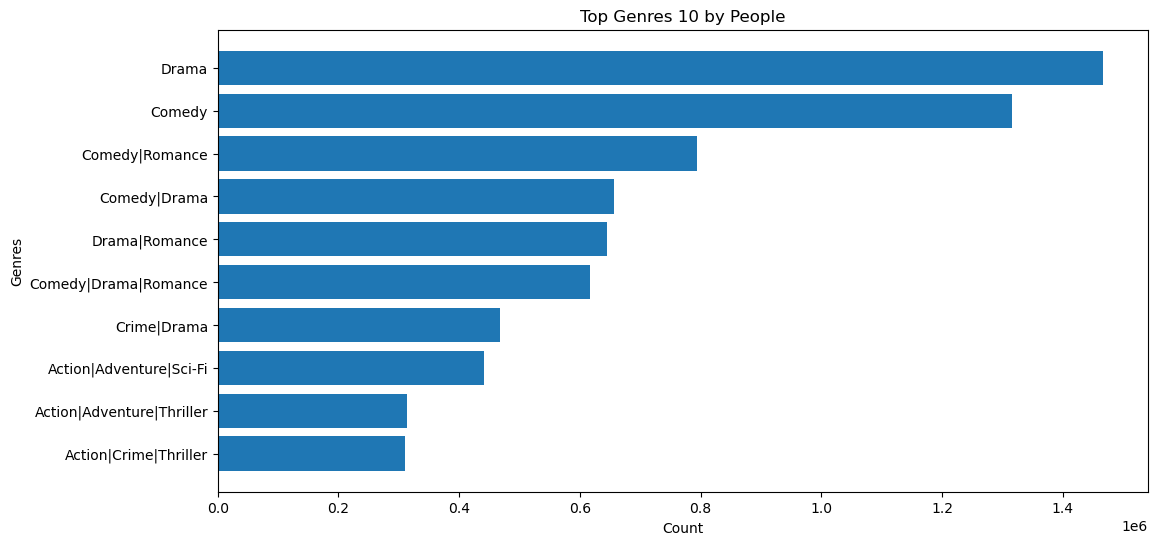

DataFrame[genres: string, count: bigint]

In [7]:
# visualization for most watched genres by people
import matplotlib.pyplot as plt
import seaborn as sns
genre_vis = genre_counts.toPandas()
plt.figure (figsize=(12,6))
plt.barh(genre_vis['genres'], genre_vis['count'])
plt.xlabel('Count')
plt.ylabel('Genres')
plt.title('Top Genres 10 by People')
plt.gca().invert_yaxis()  # Invert the y-axis for better readability
plt.show()

genre_counts.unpersist()

people just love drama and it is so sad. people should watch more documentaries and scifiction to nurture their knowledge and curiosity :(

In [8]:
# Top 10 movies by average rating
movies_by_rating = df.groupBy("title").agg(avg("rating").alias("average_rating")).orderBy('average_rating', ascending=False).limit(10)
movies_by_rating.show()

+--------------------+--------------+
|               title|average_rating|
+--------------------+--------------+
|Always for Pleasu...|           5.0|
|Neurons to Nirvan...|           5.0|
|Foster Brothers, ...|           5.0|
|A Night for Dying...|           5.0|
|Blue Swallow (Che...|           5.0|
|   Rent-a-Cat (2012)|           5.0|
|      Divorce (1945)|           5.0|
|    Marihuana (1936)|           5.0|
|Eye In The Sky (G...|           5.0|
|The Sea That Thin...|           5.0|
+--------------------+--------------+



### Simple analysis using correlation matrix

In [16]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors, DenseMatrix
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col

from pyspark.mllib.linalg.distributed import IndexedRow, IndexedRowMatrix
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql import SparkSession

In [10]:
movie_ratings = df.limit(1000).groupBy("userId").pivot("movieId").avg("rating")
movie_ratings = movie_ratings.fillna(0)

In [11]:
# Create a features vector
assembler = VectorAssembler(inputCols=movie_ratings.columns[1:], outputCol="features")
movie_ratings_vector = assembler.transform(movie_ratings).select("userId", "features")

In [18]:
# Compute pairwise cosine similarity between items
cosine_similarity = Correlation.corr(movie_ratings_vector, "features", "pearson").head()

# Get the similarity matrix
similarity_matrix = cosine_similarity[0]

In [19]:
# Show some example similarities
print(similarity_matrix)

# Stop Spark Session
spark.stop()

DenseMatrix([[ 1.        , -0.42542251,  0.12786454, ..., -0.28641219,
              -0.28641219, -0.28641219],
             [-0.42542251,  1.        , -0.34216635, ...,  0.73124951,
               0.73124951,  0.73124951],
             [ 0.12786454, -0.34216635,  1.        , ..., -0.23036067,
              -0.23036067, -0.23036067],
             ...,
             [-0.28641219,  0.73124951, -0.23036067, ...,  1.        ,
               1.        ,  1.        ],
             [-0.28641219,  0.73124951, -0.23036067, ...,  1.        ,
               1.        ,  1.        ],
             [-0.28641219,  0.73124951, -0.23036067, ...,  1.        ,
               1.        ,  1.        ]])
